In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
carneige = pd.read_excel('/Users/jacopobinati/Library/CloudStorage/GoogleDrive-jacopo.binati@galamboscapital.com/My Drive/Datasets_Galambos/performances_trading.xlsx', sheet_name="HouseOTRSun")
carneige.drop(columns=["Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16", 
                       "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "index",], inplace=True)

carneige.dropna(inplace=True)
carneige['date'] = pd.to_datetime(carneige['date'], format='%Y-%m-%d')
carneige.rename(columns={"date": "Date"}, inplace=True)
carneige.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 1 to 89
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 89 non-null     datetime64[ns]
 1   equity used          89 non-null     float64       
 2   position size        89 non-null     float64       
 3   netprofit            89 non-null     float64       
 4   returns on equity    89 non-null     float64       
 5   returns on position  89 non-null     float64       
 6   leverage used        89 non-null     float64       
 7   cumulative returns   89 non-null     float64       
 8   win                  89 non-null     object        
 9   baseline             89 non-null     int64         
 10  10000$ invested      89 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 8.3+ KB


In [3]:
carneige.head()
carneige['cummulative_returns_carneige'] = ((1 + carneige['returns on equity']).cumprod() - 1)*100
carneige['returns on equity'] = (carneige['returns on equity']*100).round(2)

<Axes: xlabel='Date', ylabel='cummulative_returns_carneige'>

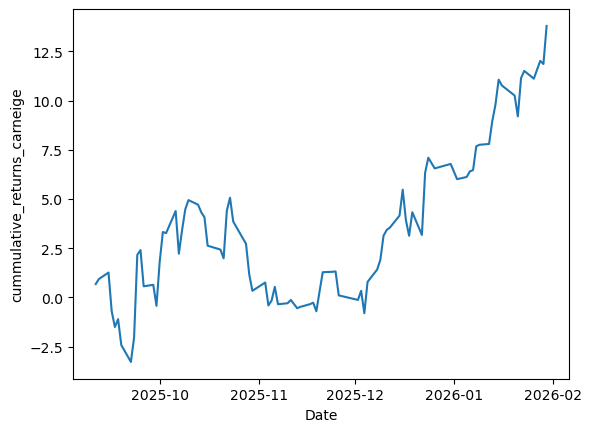

In [4]:
sns.lineplot(data=carneige, x="Date", y="cummulative_returns_carneige")

In [5]:
competitors = pd.read_excel("/Users/jacopobinati/Desktop/GalambosC/other_projects/ndx_vs_carneige/competitors.xlsx")
ticker_list = competitors['ticker'].tolist()
print(ticker_list)

['0P00018M6G.F', '0P0000I0VQ.F', '0P0000I0VU.F', '0P000017SQ.F', '0P000016DZ.F', 'RK1X.SG', 'RK1Y.SG', '0P00017BQP', '0P0001IL6A.F', 'EWO']


In [8]:
import yfinance as yf
import pandas as pd

start_date = "2025-09-10"
end_date = "2026-01-30"
ticker_list = competitors['ticker'].tolist()

comp_data = yf.download(ticker_list, start=start_date, end=end_date, auto_adjust=True)['Close']

comp_data_clean = comp_data.dropna(axis=1, how='all')

comp_data_filled = comp_data_clean.ffill().bfill()

comp_returns = comp_data_filled.pct_change(fill_method=None).dropna()
comp_cum_returns = ((1 + comp_returns).cumprod() - 1) * 100

comp_cum_returns = comp_cum_returns.reset_index()

if comp_cum_returns.empty:
    print("Warning: No valid data found for the specified tickers/dates.")
else:
    print(f"Successfully processed {comp_cum_returns.shape[1]-1} competitors.")

[*********************100%***********************]  10 of 10 completed

2 Failed downloads:
['RK1Y.SG', 'RK1X.SG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-10 -> 2026-01-30)')


Successfully processed 8 competitors.


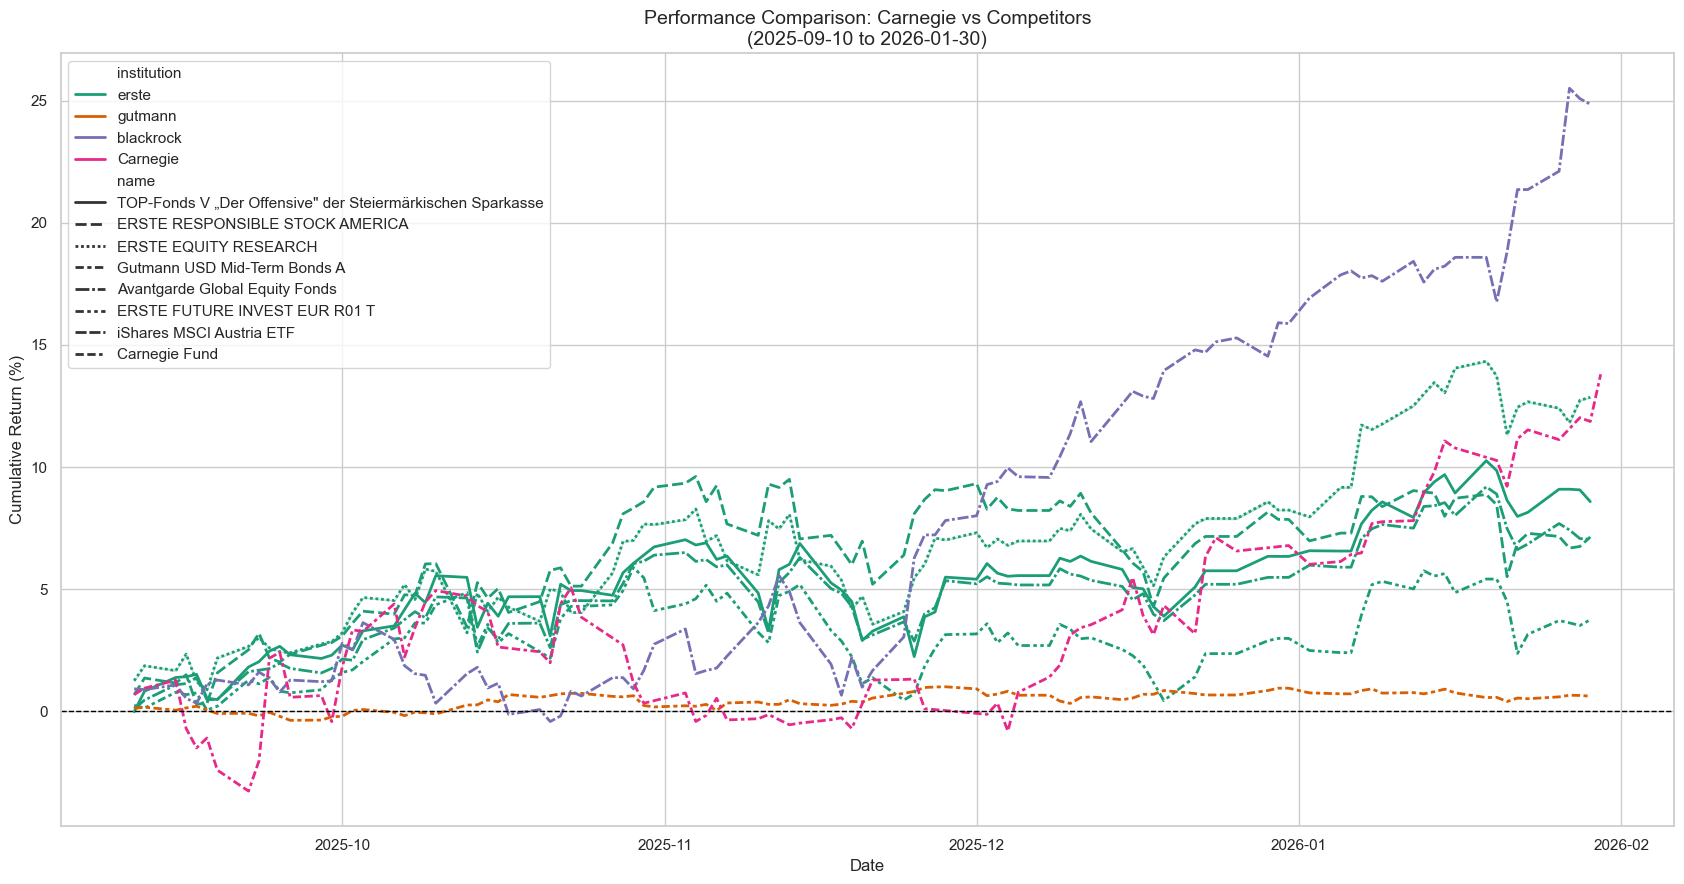

In [11]:
# 1. Melt to long-form
comp_long = comp_cum_returns.melt(id_vars='Date', var_name='ticker', value_name='Cumulative_Return')

# 2. Merge with metadata
comp_final = pd.merge(comp_long, competitors[['ticker', 'name', 'institution']], on='ticker')

# 3. Align your Carnegie data
carneige_subset = carneige[carneige['Date'] >= start_date].copy()
# Recalculate to ensure 0% start at the specific date
carneige_subset['Cumulative_Return'] = ((1 + carneige_subset['returns on equity']/100).cumprod() - 1) * 100

carneige_plot_data = carneige_subset[['Date', 'Cumulative_Return']].copy()
carneige_plot_data['name'] = 'Carnegie Fund'
carneige_plot_data['institution'] = 'Carnegie'

# 4. Combine
full_comparison = pd.concat([comp_final, carneige_plot_data], ignore_index=True)

# 5. Plotting
plt.figure(figsize=(17, 9))
sns.set_theme(style="whitegrid")

sns.lineplot(
    data=full_comparison, 
    x="Date", 
    y="Cumulative_Return", 
    hue="institution", 
    style="name", 
    palette="Dark2", 
    linewidth=2
)

plt.axhline(0, color='black', lw=1, ls='--')
plt.title(f"Performance Comparison: Carnegie vs Competitors\n({start_date} to {end_date})", fontsize=14)
plt.ylabel("Cumulative Return (%)")
plt.legend( loc='upper left')
plt.tight_layout()
plt.show()